In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

Import de données

In [20]:
# Create dictionary to store dataFrames for the 40 CAC40 companies
Data10y_dic = {}

# Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
directory = "Data/CAC40 daily 10y"
files = [f for f in os.listdir(directory) if 'Data' in f]
# Process each file
for file in files:
    # Get company name (first word before '_')
    company = file.split('_')[0]
    
    # Read the file with tab separator
    df = pd.read_csv(os.path.join(directory, file), sep='\t')
    
    # Convert first column to datetime and set as index
    df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

    df = df.drop('date', axis=1)  # Remove the original date column
    df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
    
    # Store in dictionary
    Data10y_dic[company] = df

print(f"Loaded {len(Data10y_dic)} companies' data")

Loaded 40 companies' data


In [32]:
# Create list of DataFrames with only 'clot' column
dfs = [df['clot'] for df in Data10y_dic.values()]
histo_CAC40 = pd.concat(dfs, axis=1, keys=Data10y_dic.keys())
histo_CAC40 = histo_CAC40.sort_index()

print(f"Shape of historical data: {histo_CAC40.shape}")
print("\nFirst few rows:")

Shape of historical data: (2562, 40)

First few rows:


In [56]:
data.columns

Index(['ACCOR', 'AIRBUS', 'AIRLIQUIDE', 'ARCELORMITTAL', 'AXA', 'BNPPARIBAS',
       'BOUYGUES', 'BUREAUVERITAS', 'CAPGEMINI', 'CARREFOUR',
       'CREDITAGRICOLESA', 'DANONE', 'DASSAULTSYSTEMES', 'EDENRED', 'ENGIE',
       'ESSILORLUXOTTICA', 'EUROFINSSCIENTIFIC', 'HERMESINTL', 'KERING',
       'LEGRAND', 'LOREAL', 'LVMH', 'MICHELIN', 'ORANGE', 'PERNODRICARD',
       'PUBLICISGROUPE', 'RENAULT', 'SAFRAN', 'SAINTGOBAIN', 'SANOFI',
       'SCHNEIDERELECTRIC', 'SOCIETEGENERALE', 'STELLANTIS',
       'STMICROELECTRONICS', 'TELEPERFORMANCE', 'THALES', 'TOTALENERGIES',
       'UNIBAILRODAMCOWESTFIELD', 'VEOLIA', 'VINCI'],
      dtype='object')

In [33]:
# Drop rows with NaN values
histo_CAC40_woNaN = histo_CAC40.dropna()
print(f"Shape after dropping NaN rows: {histo_CAC40_woNaN.shape}")

Shape after dropping NaN rows: (1733, 40)


Data cleaning

Calcul des rendements, volatilités et corrélations

In [38]:
data = histo_CAC40_woNaN
# Calcul du vecteur de rendement moyen annuel
mu_annuel = np.log((data.iloc[-1, :]/data.iloc[0,:])) / (data.index[-1] - data.index[0]).days * 365.25

print("Rendements annuels :")
print(mu_annuel.head())

Rendements annuels :
ACCOR            0.004419
AIRBUS           0.079696
AIRLIQUIDE       0.117772
ARCELORMITTAL    0.009012
AXA              0.085678
dtype: float64


In [40]:
delta_année = data.index.to_series().diff().dt.days.iloc[1:] / 365.25
deltat_r = pd.DataFrame(delta_année.values[:, None] * mu_annuel.values, columns=mu_annuel.index, index=delta_année.index)
nb_jour_pan = data.shape[0] / (data.index[-1] - data.index[0]).days * 365.25
Volatilite_annuel = np.sqrt((np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).var() * nb_jour_pan)
mat_correlation = (np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).corr()

print("\nVolatilités :")
print(Volatilite_annuel.head(10))


Volatilités :
ACCOR            0.339800
AIRBUS           0.383788
AIRLIQUIDE       0.205384
ARCELORMITTAL    0.440093
AXA              0.258854
BNPPARIBAS       0.332311
BOUYGUES         0.280888
BUREAUVERITAS    0.235179
CAPGEMINI        0.306073
CARREFOUR        0.267568
dtype: float64


In [41]:
print("\nMatrice de correlation :")
print(mat_correlation.iloc[ :7, :7])


Matrice de correlation :
                  ACCOR    AIRBUS  AIRLIQUIDE  ARCELORMITTAL       AXA  \
ACCOR          1.000000  0.661150    0.387920       0.510721  0.582723   
AIRBUS         0.661150  1.000000    0.446698       0.533817  0.580111   
AIRLIQUIDE     0.387920  0.446698    1.000000       0.445114  0.527762   
ARCELORMITTAL  0.510721  0.533817    0.445114       1.000000  0.588253   
AXA            0.582723  0.580111    0.527762       0.588253  1.000000   
BNPPARIBAS     0.610473  0.600759    0.459475       0.618786  0.735939   
BOUYGUES       0.565816  0.590450    0.486175       0.540304  0.618152   

               BNPPARIBAS  BOUYGUES  
ACCOR            0.610473  0.565816  
AIRBUS           0.600759  0.590450  
AIRLIQUIDE       0.459475  0.486175  
ARCELORMITTAL    0.618786  0.540304  
AXA              0.735939  0.618152  
BNPPARIBAS       1.000000  0.619075  
BOUYGUES         0.619075  1.000000  


In [48]:
#On travaille à la maille journalière
log_return_jounalier_histo = np.log(data/data.shift(1))
log_return_jounalier_histo.iloc[0, :] = 0
log_return_jounalier_histo.head()

,ACCOR,AIRBUS,AIRLIQUIDE,ARCELORMITTAL,AXA,BNPPARIBAS,BOUYGUES,BUREAUVERITAS,CAPGEMINI,CARREFOUR,...,SCHNEIDERELECTRIC,SOCIETEGENERALE,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAILRODAMCOWESTFIELD,VEOLIA,VINCI
date,,,,,,,,,,,,,,,,,,,,,
2018-06-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-06-06,-0.003988,0.010252,0.010074,0.027682,-0.004613,0.010673,0.007562,0.004687,-0.000871,-0.015689,...,0.001895,-0.002299,0.014226,0.014078,-0.000733,-0.002764,0.008014,-0.001300,-0.009355,0.000473
2018-06-07,-0.023361,-0.003506,-0.001826,-0.025244,0.007829,0.007792,-0.005035,-0.004208,-0.010958,-0.001987,...,0.003510,0.007116,0.008280,-0.010305,0.002197,-0.003234,0.012434,0.007774,0.001026,-0.004009
2018-06-08,-0.013730,0.012466,0.000000,-0.024827,0.000000,-0.007606,-0.011168,0.011625,-0.002206,-0.011936,...,-0.008119,-0.006438,-0.005334,-0.009461,0.004380,0.021063,-0.005270,-0.008295,-0.006768,-0.003549
2018-06-11,0.008032,0.000000,0.011812,0.019596,0.008450,0.018085,0.004584,0.000474,0.003527,0.004305,...,0.008658,0.015713,-0.005362,0.014626,0.000728,-0.006820,0.005711,-0.013099,0.003904,0.001660


In [ ]:
nb_stocks = log_return_jounalier_histo.shape[1]
allocations_EW = np.ones(nb_stocks) / nb_stocks

# Import the weights data of CAC40
CAC40_weights_df = pd.read_csv('Data/Poids des entreprises dans le CAC40.csv', sep=';').set_index('Societe')
# Convert string values to float
CAC40_weights = CAC40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values

In [75]:
def generate_evolution(logReturn, allocation, T_rebalancement=-1):
    nb_periods = logReturn.shape[0]
    nb_stocks = logReturn.shape[1]
    
    evolution = logReturn * 0.0
    
    if T_rebalancement == -1:
        # Buy and hold strategy
        evolution = np.exp(np.cumsum(logReturn)) * allocation
    else:
        # Rebalancing strategy
        evolution.iloc[:T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[:T_rebalancement, :])) * allocation
        
        for i in range(T_rebalancement, nb_periods, T_rebalancement):
            evolution.iloc[i:i+T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[i:i+T_rebalancement, :])) * evolution.iloc[i-1, :].sum() * allocation
        last_period = (nb_periods//T_rebalancement)*T_rebalancement
        evolution.iloc[last_period:, :] = np.exp(np.cumsum(logReturn.iloc[last_period:, :])) * evolution.iloc[last_period-1, :].sum() * allocation
    
    return evolution


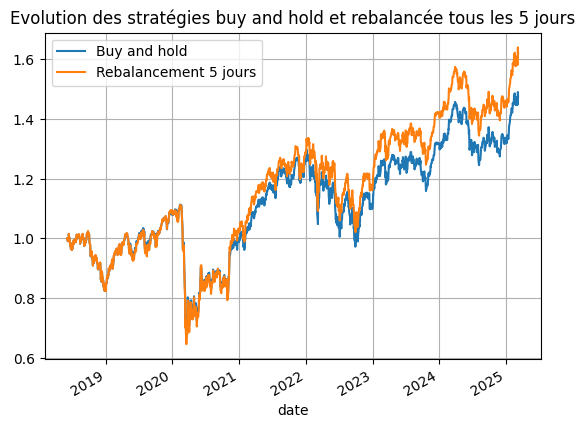

In [84]:
# Exemple d'utilisation

allocation = CAC40_weights
#allocation = allocations_EW
evolution_huyHold = generate_evolution(log_return_jounalier_histo, allocation)
evolution_Rebal = generate_evolution(log_return_jounalier_histo, allocation, T_rebalancement = 5)
evolution_huyHold.sum(axis=1).plot(label="Buy and hold")
evolution_Rebal.sum(axis=1).plot(label="Rebalancement 5 jours")
plt.title("Evolution des stratégies buy and hold et rebalancée tous les 5 jours")
plt.legend()
plt.grid()
plt.show()

In [85]:
def generate_scenarios(rendement, volatilities, correlationMatrix, nb_scenario, BeginDate, EndDate, seed=1):
    np.random.seed(seed)
    nb_stocks = len(volatilities)
    
    # Génération des dates excluant les samedis et dimanches
    dates = pd.date_range(start=BeginDate, end=EndDate, freq='B')
    nb_periods = len(dates)
    
    # Calcul du facteur d'ajustement pour les volatilities
    delta_t = dates.to_series().diff().dt.days[1:] / 365.25
    delta_t = np.insert(delta_t, 0, 0)  # Insert 0 at the beginning
    adjustment_factor = np.sqrt(delta_t)
    
    # Génération de scénarios de log-rendements
    log_returns = np.random.normal(0, 1, (nb_periods, nb_stocks, nb_scenario))
    cholesky_matrix = np.linalg.cholesky(correlationMatrix)
    
    for i in range(nb_scenario):
        log_returns[:, :, i] = log_returns[:, :, i] @ cholesky_matrix.T
    
    log_returns = log_returns * (volatilities.values[:, None] * adjustment_factor[:, None, None])
    
    # Ajout du rendement moyen annuel
    mean_returns = (rendement.values[:, None] / 256.2305133079848) * delta_t[:, None, None]
    log_returns += mean_returns
    
    # Création du dictionnaire de DataFrames
    scenarios = {f'Scenario {i+1}': pd.DataFrame(log_returns[:, :, i], index=dates, columns=volatilities.index) for i in range(nb_scenario)}
    
    return scenarios

In [ ]:
# Définir les dates de début et de fin
BeginDate = '2025-03-10'
EndDate = '2035-03-10'

# Générer les scénarios
scenarios = generate_scenarios(mu_annuel, Volatilite_annuel, mat_correlation, nb_scenario=100, BeginDate=BeginDate, EndDate=EndDate, seed=250)

# Afficher les premiers scénarios pour vérifier
if False:
    for scenario_name, scenario_data in scenarios.items():
        print(f"{scenario_name}:\n", scenario_data.head(), "\n")

Scenario 1:
                ACCOR    AIRBUS  AIRLIQUIDE  ARCELORMITTAL       AXA  \
2025-03-10  0.000000  0.000000    0.000000       0.000000  0.000000   
2025-03-11 -0.017868 -0.030065   -0.005621      -0.003409 -0.005515   
2025-03-12  0.004193  0.005888    0.000970      -0.001283  0.000262   
2025-03-13  0.002895 -0.001845   -0.008760       0.007914 -0.007394   
2025-03-14 -0.019062  0.016312    0.010656      -0.017088  0.013155   

            BNPPARIBAS  BOUYGUES  BUREAUVERITAS  CAPGEMINI  CARREFOUR  ...  \
2025-03-10    0.000000  0.000000       0.000000   0.000000  -0.000000  ...   
2025-03-11   -0.005221 -0.009710       0.008883  -0.018862   0.005562  ...   
2025-03-12   -0.003838 -0.005617      -0.005394  -0.020089   0.005051  ...   
2025-03-13    0.002779  0.014014      -0.013087  -0.019972   0.021394  ...   
2025-03-14    0.012825 -0.003536      -0.004334   0.006546  -0.005849  ...   

            SCHNEIDERELECTRIC  SOCIETEGENERALE  STELLANTIS  \
2025-03-10           0.000000

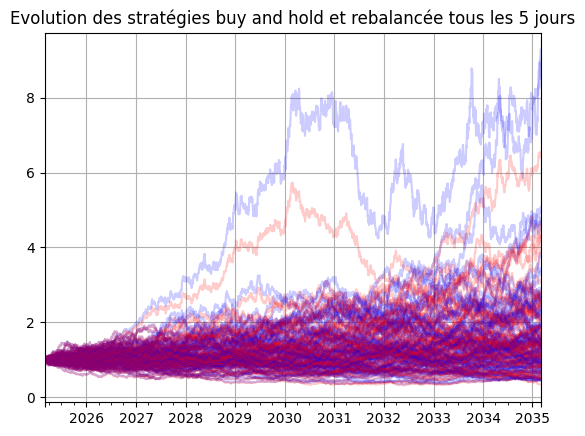

In [54]:
# Exemple d'utilisation
allocation = np.ones(nb_stocks) / nb_stocks
i=0

for scenario_name, scenario_data in scenarios.items():
    evolution_huyHold_sce1 = generate_evolution(scenario_data, allocation)
    evolution_Rebal_sce1 = generate_evolution(scenario_data, allocation, T_rebalancement = 20)
    evolution_huyHold_sce1.sum(axis=1).plot(color="blue", alpha=0.2)
    evolution_Rebal_sce1.sum(axis=1).plot(color="red", alpha=0.2)
    i+=1
plt.title("Evolution des stratégies buy and hold et rebalancée tous les 5 jours")
#plt.legend()
plt.grid()
plt.show()